In [1]:
import mpramnist
from mpramnist.Sharpr.dataset import SharprDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Sharpr

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as L

# Initiate some parameters

In [2]:
BATCH_SIZE = 512
NUM_WORKERS = 103

In [3]:
SharprDataset.ACTIVITY_COLUMNS

['k562_minp_rep1',
 'k562_minp_rep2',
 'k562_minp_avg',
 'k562_sv40p_rep1',
 'k562_sv40p_rep2',
 'k562_sv40p_avg',
 'hepg2_minp_rep1',
 'hepg2_minp_rep2',
 'hepg2_minp_avg',
 'hepg2_sv40p_rep1',
 'hepg2_sv40p_rep2',
 'hepg2_sv40p_avg']

In [4]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])
test_transform = t.Compose([
    t.Seq2Tensor(), 
])

In [5]:
# load the data
train_dataset = SharprDataset(split="train", transform=train_transform, root = "../data/")# for needed folds

val_dataset = SharprDataset( split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SharprDataset( split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [6]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset SharprDataset of size 457174 (MpraDaraset)
    Number of datapoints: 457174
    Used split fold: train
Dataset SharprDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Used split fold: val
Dataset SharprDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Used split fold: test


In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [8]:
in_channels = len(train_dataset[0][0])
out_channels = len(SharprDataset.ACTIVITY_COLUMNS)

In [27]:
batch = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([64, 4, 145])
torch.Size([64, 12])


In [8]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

model = HumanLegNet(in_ch=4,
                                 num_outputs = 12,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[256, 128, 128, 128, 64, 64],
                                 pool_sizes=[2,2,2,2,2,2],
                                 resize_factor=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 1e-2)
'''
model = Malinois()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                         lr=1e-7, weight_decay=1e-2, 
                                         betas=(0.8661062881299633, 0.879223105336538), amsgrad=True)
'''
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 1e-2)
criterion = nn.MSELoss() 

In [9]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.59E-03


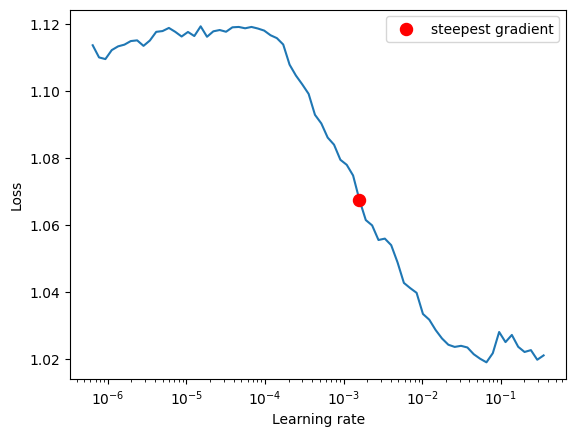

In [10]:
lr_finder.plot()  
plt.show()

In [9]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = out_channels,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sharpr(model = model,
                           loss = nn.MSELoss(), 
                           activity_columns = SharprDataset.ACTIVITY_COLUMNS,
                           weight_decay = 1e-2, lr = 1e-2, print_each = 1)

In [10]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | model         | HumanLegNet     | 1.3 M  | train
1 | loss          | MSELoss         | 0      | train
2 | train_pearson | PearsonCorrCoef | 0      | train
3 | val_pearson   | PearsonCorrCoef | 0      | train
4 | test_pearson  | PearsonCorrCoef | 0      | train
----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.301  

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=1` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Loss: 0.94326 | Val Pearson: k562_minp_rep1 : 0.26447242498397827, k562_minp_rep2 : 0.3310558795928955, k562_minp_avg : 0.3448077440261841, k562_sv40p_rep1 : 0.15791040658950806, k562_sv40p_rep2 : 0.1579209268093109, k562_sv40p_avg : 0.18070125579833984, hepg2_minp_rep1 : 0.2094680517911911, hepg2_minp_rep2 : 0.20864622294902802, hepg2_minp_avg : 0.23606589436531067, hepg2_sv40p_rep1 : 0.2315375655889511, hepg2_sv40p_rep2 : 0.1984216570854187, hepg2_sv40p_avg : 0.25001657009124756, | Train Pearson: 0.22451 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          test_loss               0.9432611465454102
 test_pearson_hepg2_minp_avg      0.23606589436531067
test_pearson_hepg2_minp_rep1      0.2094680517911911
test_pearson_hepg2_minp_rep2      0.20864622294902802
test_pearson_hepg2_sv40p_avg      0.25001657009124756
test_pearson_hepg2_sv40p_rep1     0.2315375655889511
test_pearson_hepg2_sv40p_rep2     0.1984216570854187
 test_pearson_k562_minp_avg       0.3448077440261841
 test_pearson_k562_minp_rep1      0.26447242498397827
 test_pearson_k562_minp_rep2      0.3310558795928955
 test_pearson_k562_sv40p_avg      0.18070125579833984
test_pearson_k562_sv40p_rep1      0.15791040658950806
test_pearson_k562_sv40p_rep2      0.1579209268093109
─────────────

[{'test_loss': 0.9432611465454102,
  'test_pearson_k562_minp_rep1': 0.26447242498397827,
  'test_pearson_k562_minp_rep2': 0.3310558795928955,
  'test_pearson_k562_minp_avg': 0.3448077440261841,
  'test_pearson_k562_sv40p_rep1': 0.15791040658950806,
  'test_pearson_k562_sv40p_rep2': 0.1579209268093109,
  'test_pearson_k562_sv40p_avg': 0.18070125579833984,
  'test_pearson_hepg2_minp_rep1': 0.2094680517911911,
  'test_pearson_hepg2_minp_rep2': 0.20864622294902802,
  'test_pearson_hepg2_minp_avg': 0.23606589436531067,
  'test_pearson_hepg2_sv40p_rep1': 0.2315375655889511,
  'test_pearson_hepg2_sv40p_rep2': 0.1984216570854187,
  'test_pearson_hepg2_sv40p_avg': 0.25001657009124756}]